## Analysis Hotel's Review with NLP Techniques

### 1. Exploratory Data Analysis (EDA)

In the first step, we read the data and do eyeballing:

In [1]:
# Import plotly and pandas
import pandas as pd
df = pd.read_excel("guest_data_with_reviews.xlsx")
df.head(3)

,ID,Start time,Completion time,Email,Name,Full Name,Gender,Date of Birth,Checkout Date,Purpose of the visit,How did you discover us?,Rate your overall experience in our hotel,How likely are you to recommend us to a friend or colleague?,Staff attitude,Check-in Process,Room service,Room cleanliness,Food quality,Variety of food,Broadband & TV,Gym,Review
0,1,NaN,NaN,NaN,NaN,Guest 00001,Male,1993-10-02,2022-04-07,Business,Organization,3,9,Good,Good,Very good,Poor,Very good,Average,Excellent,Excellent,it was an okay experience overall. the room wa...
1,3,NaN,NaN,NaN,NaN,Guest 00003,Male,1981-10-03,2020-01-16,Vacation,News paper,4,4,Poor,Good,Very good,Average,Poor,Poor,Good,Very good,the stay was memorable thanks to the poor staf...
2,4,NaN,NaN,NaN,NaN,Guest 00004,Male,2004-03-31,2022-05-14,Vacation,Search engine,5,6,Good,Very good,Good,Poor,Average,Poor,Poor,Excellent,while the staff were good and did their best t...


Next we wouldl like to know What's the total length of the dataset?

In [2]:
total_length = len(df)
total_length

1108

In the next step, just because having better understanding about data, we need to find the total number of missing values

In [3]:
missing_values = df.isnull().sum()
missing_values

ID                                                                 0
Start time                                                      1108
Completion time                                                 1108
Email                                                           1108
Name                                                            1108
Full Name                                                          0
Gender                                                             0
Date of Birth                                                      0
Checkout Date                                                      0
Purpose of the visit                                               0
How did you discover us?                                           0
Rate your overall experience in our hotel                          0
How likely are you to recommend us to a friend or colleague?       0
Staff attitude                                                     0
Check-in Process                  

For us, it makes sense we have missing values for personal information columns. So we can totally drop those columns. Also we don't need extra columns for our purpose.

In [29]:
df_cleaned = df[['ID',
                 'How likely are you to recommend us to a friend or colleague?',
                 'Review']]

df_cleaned.head(3)

,ID,How likely are you to recommend us to a friend or colleague?,Review
0,1,9,it was an okay experience overall. the room wa...
1,3,4,the stay was memorable thanks to the poor staf...
2,4,6,while the staff were good and did their best t...


We're interested in the recommendation scores. What is their distribution? and we wouldl like to know more about it.

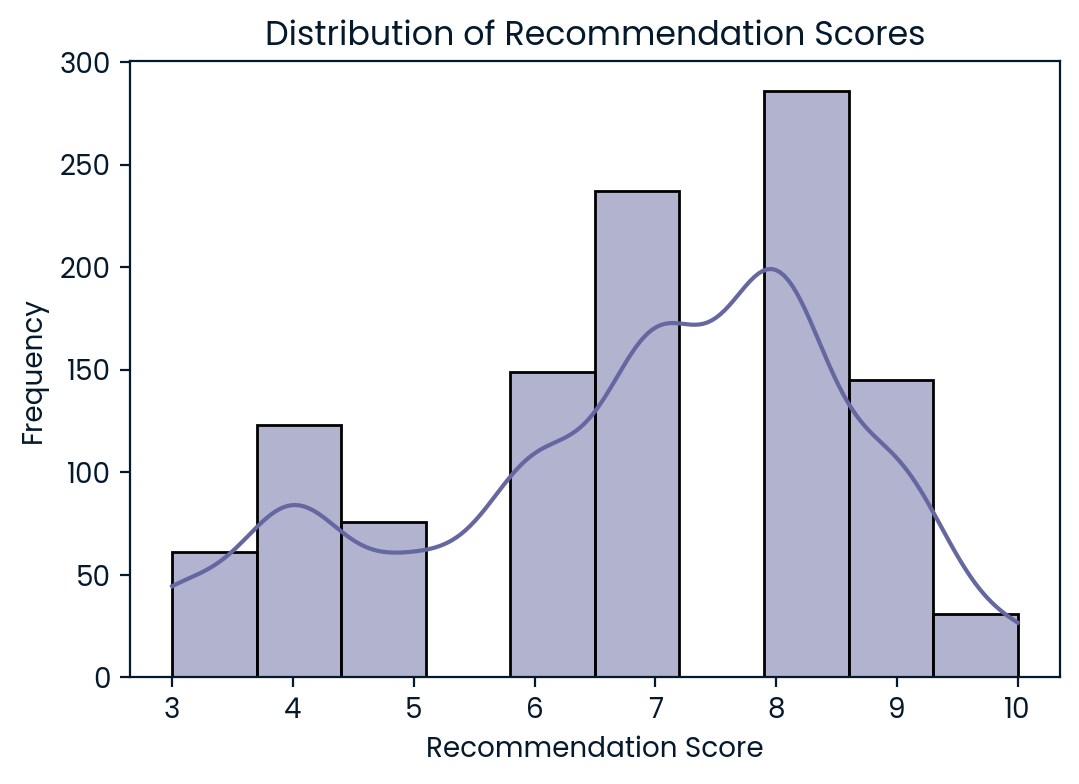

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

col_preference = "How likely are you to recommend us to a friend or colleague?"

plt.figure(figsize=(6, 4))

sns.histplot(
    df_cleaned[col_preference], 
    bins = 10, 
    kde = True)

plt.title("Distribution of Recommendation Scores")
plt.xlabel("Recommendation Score")
plt.ylabel("Frequency")
plt.show()

The histogram shows that most recommendation scores are concentrated between 7 and 9, indicating generally high user satisfaction and a strong willingness to recommend the product or service.

The distribution is left-skewed (negatively skewed), with fewer low scores in the 3–5 range. This suggests that negative experiences exist but are relatively uncommon.

Multiple peaks around 4, 7, and 8 indicate the presence of different user sentiment groups, such as dissatisfied users, moderately satisfied users, and strong promoters.

Overall, the data suggests a positively biased and potentially imbalanced sentiment distribution, which should be considered in later modeling or sentiment classification steps.

### 2. Calculate NPS

In this step, we want to classify the recommended number to some meaningful categories to be able to do sentiment analysis on them:
- Promoters (9 - 10)
- Passivies (7 - 8)
- Detractors (0 - 6)

In [6]:
# Create function
def classify_nps(score):
    if score >= 9:
        return 'Promoter'
    elif score >= 7:
        return 'Passive'
    else:
        return 'Detractor'

In [30]:
# Apply the function
df_cleaned['NPS Category'] = df_cleaned["How likely are you to recommend us to a friend or colleague?"].apply(classify_nps)

df_cleaned.head(3)

,ID,How likely are you to recommend us to a friend or colleague?,Review,NPS Category
0,1,9,it was an okay experience overall. the room wa...,Promoter
1,3,4,the stay was memorable thanks to the poor staf...,Detractor
2,4,6,while the staff were good and did their best t...,Detractor


Now, we can see What proportion of customers are promoters, passives, and detractors?

In [8]:
nps_proportions = df_cleaned['NPS Category'].value_counts(normalize=True) * 100
nps_proportions

NPS Category
Passive      47.202166
Detractor    36.913357
Promoter     15.884477
Name: proportion, dtype: float64

In this step, we calculate the Net Promoter Score (NPS) by comparing the proportion of promoters and detractors relative to all responses.

NPS provides a high-level measure of customer loyalty and satisfaction, helping assess how likely users are to recommend the product or service.

NPS can range from -100 to 100.
- A positive NPS (>0) is generally considered good, with higher scores indicating better customer satisfaction and loyalty.
- An NPS of 50 or more is considered excellent.
- An NPS below 0 indicates that there are more detractors than promoters, which is a sign of customer dissatisfaction.

In [9]:
# Calculate the number of promoters, passives, and detractors
promoters = df_cleaned[df_cleaned['NPS Category'] == 'Promoter'].shape[0]
passives = df_cleaned[df_cleaned['NPS Category'] == 'Passive'].shape[0]
detractors = df_cleaned[df_cleaned['NPS Category'] == 'Detractor'].shape[0]

# Calculate the total number of responses
total_responses = df_cleaned.shape[0]

# Calculate the NPS score
nps_score = ((promoters - detractors) / total_responses) * 100

# Display the NPS score
if nps_score > 50:
    loyalty_interpretation = "Excellent customer loyalty"
elif nps_score > 0:
    loyalty_interpretation = "Good customer loyalty"
else:
    loyalty_interpretation = "Poor customer loyalty"

print(nps_score)
print(loyalty_interpretation)

-21.028880866425993
Poor customer loyalty


### 3. Sentiment Analysis 

At this moment, we start to do sentiment analysis on comments. For doing this, we use a pre-trained model. For use a model is called `sentiment-analysis`.

In [11]:
from transformers import pipeline

sentiment_analyzer = pipeline('sentiment-analysis')

2025-12-27 23:47:38.942028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766879258.956833     454 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766879258.961439     454 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766879258.973720     454 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766879258.973736     454 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766879258.973738     454 computation_placer.cc:177] computation placer alr

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


Now, we apply that model on column review. This model does all the steps of preprocessing and clean of text which saves time for us. 

We create a column as Sentiment and then apply a lamda function on it. The lamda function get every single row for the column review and apply the model on that and then save the results of lable.

In [31]:
# Analyze sentiments in the reviews
df_cleaned['Sentiment'] = df_cleaned['Review'] \
                        .apply(lambda review: sentiment_analyzer(review)[0]['label'])

df_cleaned.head(3)

,ID,How likely are you to recommend us to a friend or colleague?,Review,NPS Category,Sentiment
0,1,9,it was an okay experience overall. the room wa...,Promoter,POSITIVE
1,3,4,the stay was memorable thanks to the poor staf...,Detractor,NEGATIVE
2,4,6,while the staff were good and did their best t...,Detractor,NEGATIVE


Now, let's visualize the sentiment analysis to see how many positive and how many negative comments we have.

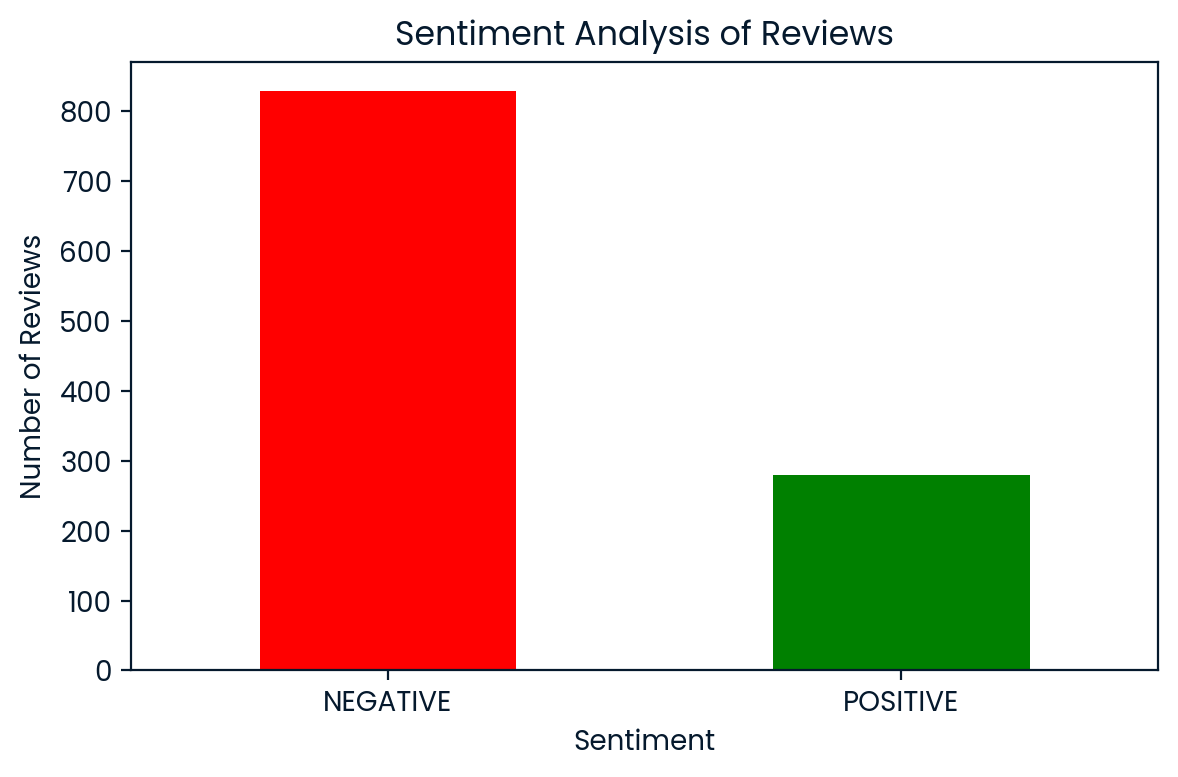

In [14]:
# Count the occurrences of each sentiment
sentiment_counts = df_cleaned['Sentiment'].value_counts()

plt.figure(figsize=(6,4))

sentiment_counts.plot(kind='bar', 
                      color=['red', 
                             'green'])

plt.title('Sentiment Analysis of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 4. Topic Modeling

Now that we know most of the comments are negative, we would like to know which kind of topics the customers focused and emphasized. This is crucial for managers to know that.

First of all we should convert all the reviews to a list.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract the reviews from the dataframe
reviews = df_cleaned['Review'].dropna().tolist()
reviews

['it was an okay experience overall. the room was poor, but the staff tried to make up for it with their good approach. food was a bit very good, could use some work.',
 'the stay was memorable thanks to the poor staff. unfortunately, the cleanliness of the room and the quality of food didn’t match my expectations.',
 'while the staff were good and did their best to assist, the room and dining experience could have been improved. it wasn’t the best, but not the worst either.',
 'the hotel experience was average at best. the team was excellent, but the room cleanliness and food quality seemed like afterthoughts. i hope they focus on these areas in the future.',
 'not my favorite stay, but the good staff helped. still, the food and room need significant upgrades for me to consider returning.',
 'the stay was memorable thanks to the very good staff. unfortunately, the cleanliness of the room and the quality of food didn’t match my expectations.',
 'the hotel experience was average at best

Then, we initalize the vectorizer. Also, we set English language as stop word to let model knows which kind of word should be considered as stop words.

In [16]:
vectorizer = CountVectorizer(stop_words='english', 
                             max_features = 20)

Now, we need to fit the cevtorizer or the list of reviews.

In [17]:
X = vectorizer.fit_transform(reviews)

Now, we can see the 20 most important features (topic) that model extracted from the reviews.

In [20]:
keywords = vectorizer.get_feature_names_out()

# Sum up the counts of each keyword
keyword_counts = X.toarray().sum(axis=0)

# Create a dataframe for the keywords and their counts
df_keywords = pd.DataFrame({'Keyword': keywords, 'Count': keyword_counts})

# Sort the dataframe by count in descending order
df_keywords = df_keywords.sort_values(by='Count', ascending=False)

df_keywords

,Keyword,Count
14,room,1108
7,food,1003
8,good,997
15,staff,897
16,stay,457
6,experience,454
2,cleanliness,403
1,best,314
4,excellent,307
18,wasn,306


We see most of the time, customers talking about room and food. So they are very common in the reviews and also we should consider that all sentiment was negative. It shows there are something wrong for quality of these two parameters in hotel.

<hr>

This topic modeling reveals distinct experiential themes, ranging from strong satisfaction and loyalty to service quality concerns, which can later be aligned with sentiment scores or NPS categories.

In [21]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', 
                                   max_features = 1000)

In [23]:
# Fit and transform the reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

In [24]:
# Initialize the LDA model
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 42)

In [25]:
# Fit the LDA model to the tfidf matrix
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [26]:
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx+1}"] = [feature_names[i] for i in topic \
                                          .argsort()[:-no_top_words - 1:-1]]
    return topics

In [27]:
# Display the topics
no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
topics = display_topics(lda, tfidf_feature_names, no_top_words)
topics

{'Topic 1': ['left',
  'hoped',
  'nice',
  'ups',
  'quite',
  'downs',
  'touch',
  'desired',
  'demeanor',
  'fell'],
 'Topic 2': ['approach',
  'make',
  'okay',
  'use',
  'bit',
  'work',
  'tried',
  'overall',
  'good',
  'experience'],
 'Topic 3': ['dragged',
  'nature',
  'stood',
  'subpar',
  'lackluster',
  'overall',
  'cleanliness',
  'experience',
  'staff',
  'food'],
 'Topic 4': ['best',
  'helped',
  'favorite',
  'upgrades',
  'need',
  'consider',
  'returning',
  'significant',
  'stay',
  'wasn'],
 'Topic 5': ['didn',
  'quality',
  'team',
  'cleanliness',
  'thanks',
  'memorable',
  'match',
  'unfortunately',
  'leave',
  'impression']}